# house price prediction

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import joblib
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer

from scipy.stats import chi2_contingency
import scipy.stats as stats
from scipy.stats import norm ,rankdata

from scipy.special import boxcox1p
from scipy.stats import normaltest
import statsmodels
import statsmodels.api as sm
from scipy.optimize import curve_fit

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import LSTM


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PowerTransformer

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import xgboost as xgb

In [2]:
df = pd.read_csv("housing_train.csv")
df.head(1)

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7039061606,https://bham.craigslist.org/apa/d/birmingham-h...,birmingham,https://bham.craigslist.org,1195,apartment,1908,3,2.0,1,...,0,0,0,laundry on site,street parking,https://images.craigslist.org/00L0L_80pNkyDeG0...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al


In [3]:
print("Data Shape: "+str(df.shape))
print()
print("Columns: "+str(df.columns))
print()
print(df.info())
print()
df.describe()

Data Shape: (265190, 22)

Columns: Index(['id', 'url', 'region', 'region_url', 'price', 'type', 'sqfeet', 'beds',
       'baths', 'cats_allowed', 'dogs_allowed', 'smoking_allowed',
       'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished',
       'laundry_options', 'parking_options', 'image_url', 'description', 'lat',
       'long', 'state'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265190 entries, 0 to 265189
Data columns (total 22 columns):
id                         265190 non-null int64
url                        265190 non-null object
region                     265190 non-null object
region_url                 265190 non-null object
price                      265190 non-null int64
type                       265190 non-null object
sqfeet                     265190 non-null int64
beds                       265190 non-null int64
baths                      265190 non-null float64
cats_allowed               265190 non-null int64
dogs_allow

,id,price,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,lat,long
count,2.651900e+05,2.651900e+05,2.651900e+05,265190.000000,265190.000000,265190.000000,265190.000000,265190.000000,265190.000000,265190.000000,265190.000000,263771.000000,263771.000000
mean,7.040888e+09,1.227285e+04,1.093678e+03,1.912414,1.483468,0.716822,0.696550,0.733896,0.078759,0.014360,0.048644,37.208855,-92.398149
std,8.778930e+06,5.376352e+06,2.306888e+04,3.691900,0.630208,0.450543,0.459749,0.441920,0.269362,0.118968,0.215124,5.659648,17.370780
min,7.003808e+09,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-43.533300,-163.894000
25%,7.035963e+09,8.170000e+02,7.520000e+02,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.508500,-104.704000
50%,7.043109e+09,1.060000e+03,9.500000e+02,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,37.984900,-86.478300
75%,7.048362e+09,1.450000e+03,1.156000e+03,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,41.168400,-81.284600
max,7.051263e+09,2.768307e+09,8.388607e+06,1100.000000,75.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,102.036000,172.633000


## 1) Data Cleaning

My plan for data preparation: 
 - drop duplicated rows if any.
 - remove outliers
 - filling missing values

### a. Drop duplicates

In [4]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

0


### b. Removing Outliers

#### price and sqfeet outlier removal

In [5]:
def feature_outlier_removal(data, feature, min_q, max_q):
    feature_min_outlier_mask = data[feature] > data[feature].quantile(min_q)
    feature_max_outlier_mask = data[feature] < data[feature].quantile(max_q)
    data = data[(feature_min_outlier_mask) & (feature_max_outlier_mask)]
    print(feature, "min: ", min(data[feature]))
    print(feature, "max: ", max(data[feature]))
    return data

def numerical_outlier_removal(data):
    data = feature_outlier_removal(data, "price", 0.01, 0.999)
    data = feature_outlier_removal(data, "sqfeet", 0.002, 0.999)
    return data

In [6]:
raw_df = numerical_outlier_removal(df)
print("\nOutliers Removed :", df.shape[0] - raw_df.shape[0])
print("Data Shape: ", raw_df.shape[0])

price min:  326
price max:  7700
sqfeet min:  54
sqfeet max:  4005

Outliers Removed : 3760
Data Shape:  261430


#### beds and baths outlier removal

In [7]:
raw_df = raw_df[raw_df['beds'] <= 6] 
raw_df = raw_df[raw_df['baths'] <= 3.5] 

print("Data Shape: ", raw_df.shape[0])

Data Shape:  260159


#### lat and long outlier removal

The valid range of latitude in degrees is -90 and +90 for the southern and northern hemisphere respectively. Longitude is in the range -180 and +180 specifying coordinates west and east of the Prime Meridian, respectively. But here we are dealing wiht US data, so, Lat-long coorditates for cities in United States are in range: Latitude from 19.50139 to 64.85694 and longitude from -161.75583 to -68.01197.

In [8]:
lat_min_mask = raw_df['lat'] >= 19.50139
lat_max_mask = raw_df['lat'] <= 64.85694
raw_df = raw_df[(lat_min_mask) & (lat_max_mask)]

long_min_mask = raw_df['long'] >= -161.75583
long_max_mask = raw_df['long'] <= -68.01197
raw_df = raw_df[(long_min_mask) & (long_max_mask)]

print("lat min: ", min(raw_df.lat))
print("lat max: ", max(raw_df.lat))
print("long min: ", min(raw_df.long))
print("long max: ", max(raw_df.long))
print("Data Shape: ", raw_df.shape[0])

lat min:  19.5295
lat max:  64.8569
long min:  -159.53
long max:  -68.2071
Data Shape:  258420


In [9]:
def Lat_long_outlier_removal(data):
    data = feature_outlier_removal(data, "lat", 0.01, 0.999)
    data = feature_outlier_removal(data, "long", 0.01, 0.999)
    return data

In [10]:
lat_long_df = Lat_long_outlier_removal(raw_df)
print("\nOutliers Removed :", raw_df.shape[0] - lat_long_df.shape[0])
print("Data Shape: ", lat_long_df.shape[0])

lat min:  25.7805
lat max:  61.601000000000006
long min:  -122.404
long max:  -70.2628

Outliers Removed : 5651
Data Shape:  252769


### c. Filling missing values

laundry_options    53174
parking_options    92535
description            2
dtype: int64


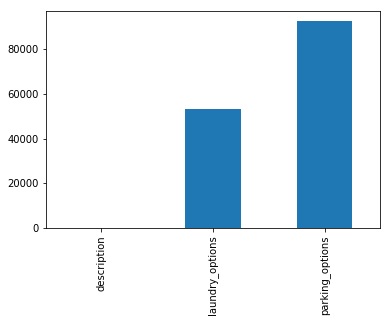

In [11]:
missing = raw_df.isnull().sum()
missing = missing[missing > 0]
print(missing)
missing.sort_values(inplace=True)
try:
    missing.plot.bar()
except:
    pass

#### work on Laundry Options: Model based imputation (filling missing values)

In [12]:
#before imputation
print(raw_df["laundry_options"].value_counts())
print(raw_df["laundry_options"].isna().sum())

w/d in unit           88578
w/d hookups           49280
laundry on site       37922
laundry in bldg       27025
no laundry on site     2441
Name: laundry_options, dtype: int64
53174


In [13]:
raw_df["laundry_options_na"] = 0
raw_df["laundry_options_na"][raw_df["laundry_options"][raw_df["laundry_options"].isna()==True].index] = 1

In [14]:
from sklearn.neighbors import KNeighborsClassifier
decide_cols = ["beds", "baths", "cats_allowed", "dogs_allowed", 
               "smoking_allowed", "wheelchair_access", "electric_vehicle_charge",
               "comes_furnished", "price" ]

X_train = raw_df[decide_cols][raw_df["laundry_options"].isna()==False]
y_train = raw_df["laundry_options"][raw_df["laundry_options"].isna()==False]
X_test = raw_df[decide_cols][raw_df["laundry_options"].isna()==True]
 
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)
laundry_pred = neigh.predict(X_test)
print(laundry_pred)
print(laundry_pred.size)

# filling missing values
raw_df["laundry_options"][raw_df["laundry_options"].isna()==True] = laundry_pred

['w/d in unit' 'w/d hookups' 'w/d hookups' ... 'laundry in bldg'
 'laundry on site' 'w/d in unit']
53174


In [15]:
#after imputation
print(raw_df["laundry_options"].value_counts())
print(raw_df["laundry_options"].isna().sum())

w/d in unit           109670
w/d hookups            63410
laundry on site        48624
laundry in bldg        34049
no laundry on site      2667
Name: laundry_options, dtype: int64
0


#### work on Parking Options: Model based imputation (filling missing values)

In [16]:
#before imputation
print(raw_df["parking_options"].value_counts())
print(raw_df["parking_options"].isna().sum())

off-street parking    86067
carport               28073
attached garage       26662
detached garage       12648
street parking        10381
no parking             1934
valet parking           120
Name: parking_options, dtype: int64
92535


In [17]:
raw_df["parking_options_na"] = 0
raw_df["parking_options_na"][raw_df["parking_options"][raw_df["parking_options"].isna()==True].index] = 1

In [18]:
from sklearn.neighbors import KNeighborsClassifier
decide_cols = ["beds", "baths", "cats_allowed", "dogs_allowed", 
               "smoking_allowed", "wheelchair_access", "electric_vehicle_charge",
               "comes_furnished", "price" ]

X_train = raw_df[decide_cols][raw_df["parking_options"].isna()==False]
y_train = raw_df["parking_options"][raw_df["parking_options"].isna()==False]
X_test = raw_df[decide_cols][raw_df["parking_options"].isna()==True]
 
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(X_train, y_train)
laundry_pred = neigh.predict(X_test)
print(laundry_pred)
print(laundry_pred.size)

# filling missing values

raw_df["parking_options"][raw_df["parking_options"].isna()==True] = laundry_pred


['off-street parking' 'attached garage' 'off-street parking' ... 'carport'
 'off-street parking' 'attached garage']
92535


In [19]:
#after imputation
print(raw_df["parking_options"].value_counts())
print(raw_df["parking_options"].isna().sum())

off-street parking    141128
carport                44725
attached garage        39685
detached garage        16452
street parking         13581
no parking              2722
valet parking            127
Name: parking_options, dtype: int64
0


#### removing remaining empty features

In [21]:
print(raw_df.isnull().sum())
raw_df.dropna(inplace=True)

id                         0
url                        0
region                     0
region_url                 0
price                      0
type                       0
sqfeet                     0
beds                       0
baths                      0
cats_allowed               0
dogs_allowed               0
smoking_allowed            0
wheelchair_access          0
electric_vehicle_charge    0
comes_furnished            0
laundry_options            0
parking_options            0
image_url                  0
description                2
lat                        0
long                       0
state                      0
laundry_options_na         0
parking_options_na         0
dtype: int64


In [22]:
clean_df = raw_df.copy()
print(clean_df.columns)
print(clean_df.info())
clean_df.describe()

Index(['id', 'url', 'region', 'region_url', 'price', 'type', 'sqfeet', 'beds',
       'baths', 'cats_allowed', 'dogs_allowed', 'smoking_allowed',
       'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished',
       'laundry_options', 'parking_options', 'image_url', 'description', 'lat',
       'long', 'state', 'laundry_options_na', 'parking_options_na'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 258418 entries, 0 to 265188
Data columns (total 24 columns):
id                         258418 non-null int64
url                        258418 non-null object
region                     258418 non-null object
region_url                 258418 non-null object
price                      258418 non-null int64
type                       258418 non-null object
sqfeet                     258418 non-null int64
beds                       258418 non-null int64
baths                      258418 non-null float64
cats_allowed               258418 non-null int64
do

,id,price,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,lat,long,laundry_options_na,parking_options_na
count,2.584180e+05,258418.000000,258418.000000,258418.000000,258418.000000,258418.000000,258418.000000,258418.000000,258418.000000,258418.000000,258418.000000,258418.000000,258418.000000,258418.000000,258418.000000
mean,7.040908e+09,1227.368303,994.217384,1.887616,1.468321,0.721118,0.700133,0.735301,0.078241,0.014519,0.043213,37.211948,-92.514286,0.205764,0.358079
std,8.780741e+06,612.498897,363.082971,0.861095,0.556511,0.448450,0.458200,0.441174,0.268552,0.119618,0.203337,5.629612,16.390909,0.404259,0.479436
min,7.003808e+09,326.000000,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.529500,-159.530000,0.000000,0.000000
25%,7.035989e+09,825.000000,755.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.513500,-104.595000,0.000000,0.000000
50%,7.043197e+09,1074.000000,950.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,37.987000,-86.469200,0.000000,0.000000
75%,7.048373e+09,1450.000000,1150.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,41.181000,-81.283900,0.000000,1.000000
max,7.051263e+09,7700.000000,4000.000000,6.000000,3.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,64.856900,-68.207100,1.000000,1.000000


## 1) Feature Engineering

My plan for data preparation:
 - firstly remove unnecessary cols
 - create sqfeet range column
 - work on url
 - work on Latitude and Longitude
 - work on description



In [23]:
try:
    clean_df = clean_df.drop(['url', 'region_url', 'image_url'], axis=1)
except:
    pass

### a. Create sqfeet range column

![img](https://www.point2homes.com/news/wp-content/uploads/2017/01/Home-Size-Table-by-Province-CA.png)

In [24]:
# def sqfeet_range_column(data, feature='sqfeet'):
#     if data[feature] < 300:
#         return 'single room'
#     if data[feature] >= 300 and data[feature] < 500:
#         return 'mini'
#     if data[feature] >= 500 and data[feature] < 1000:
#         return 'small'
#     if data[feature] >= 1000 and data[feature] < 1500:
#         return 'medium'
#     if data[feature] >= 1500 and data[feature] < 2000:
#         return 'large'
#     if data[feature] >= 2000 and data[feature] < 2500:
#         return 'extra large'
#     if data[feature] >=2500:
#         return 'mansion'
    

# clean_df['sqfeet_range'] = clean_df.apply(sqfeet_range_column, axis=1)
# clean_df.sqfeet_range.value_counts()

### b. work on url

In [25]:
# #TODO: open this
# from urllib.parse import urlparse, parse_qs
# from tqdm import tqdm
# disc = {"url_parsed_loc": [], "url_params":[], "url_path_components": []}

# for i in tqdm(range(df.shape[0]), position=0, leave=True):
#     parsed = urlparse(df.url[i])
#     disc["url_parsed_loc"].append(parsed.netloc)
    
#     params = parse_qs(parsed.query)
#     disc["url_params"].append(params)
    
#     path_components = list(filter(bool, parsed.path.split('/')))
#     disc["url_path_components"].append(path_components)


# #TODO: open this

# url_df = pd.DataFrame(disc)
# print(url_df.url_params.value_counts())
# url_df.head()

# #TODO: open this
# url_df.drop("url_params", axis=1, inplace=True)
# url_df.head()



# #TODO: open this
# cnt=0
# for i in tqdm(range(df.shape[0]), position=0, leave=True):
#     if df["region_url"][i].find(url_df["url_parsed_loc"][i]) >= 0: 
#         cnt+=1

# print("Count: "+str(cnt))
# print("Error rate: "+str(1-(cnt/df.shape[0])))

### c. work on Latitude and Longitude

In [26]:
# # TODO: open this
# from sklearn.cluster import KMeans

# sse={}
# lat_long_df = clean_df[['lat', 'long']]

# for k in tqdm(range(1, 12), position=0, leave=True):
#     kmeans = KMeans(n_clusters=k, max_iter=1000).fit(lat_long_df)
#     lat_long_df["clusters"] = kmeans.labels_
#     sse[k] = kmeans.inertia_ 
# plt.figure()
# plt.plot(list(sse.keys()), list(sse.values()))
# plt.xlabel("Number of cluster")
# plt.show()

In [27]:
kmeans = KMeans(n_clusters=8, random_state=0)
lat_long_pred = kmeans.fit_predict(clean_df[["lat", "long"]])
print(lat_long_pred.size)
clean_df['lat_long_cluster'] = lat_long_pred

258418


In [28]:
clean_df = clean_df.reset_index(drop=True)

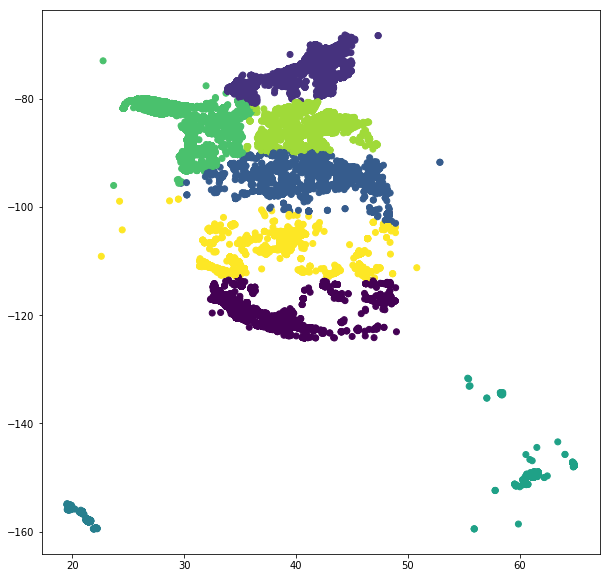

In [29]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(10,10))
plt.scatter(x=clean_df['lat'], y=clean_df['long'], c=lat_long_pred)
plt.show()

### d.work on description

In [69]:
# stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
#             "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
#             'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
#             'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
#             'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
#             'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
#             'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
#             'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
#             'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
#             'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
#             's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
#             've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
#             "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
#             "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
#             'won', "won't", 'wouldn', "wouldn't"])

In [70]:
# def decontracted(phrase):
#     # specific
#     phrase = re.sub(r"won't", "will not", phrase)
#     phrase = re.sub(r"can\'t", "can not", phrase)

#     # general
#     phrase = re.sub(r"n\'t", " not", phrase)
#     phrase = re.sub(r"\'re", " are", phrase)
#     phrase = re.sub(r"\'s", " is", phrase)
#     phrase = re.sub(r"\'d", " would", phrase)
#     phrase = re.sub(r"\'ll", " will", phrase)
#     phrase = re.sub(r"\'t", " not", phrase)
#     phrase = re.sub(r"\'ve", " have", phrase)
#     phrase = re.sub(r"\'m", " am", phrase)
#     return phrase

In [71]:
# def clean_text(sentance):
#     sentance = re.sub(r"http\S+", "", sentance)
#     sentance = BeautifulSoup(sentance, 'lxml').get_text()
#     sentance = decontracted(sentance)
#     sentance = re.sub("\S*\d\S*", "", sentance).strip()
#     sentance = re.sub('[^A-Za-z]+', ' ', sentance)
#     # https://gist.github.com/sebleier/554280
#     sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
#     return sentance.strip()

In [65]:
# for i in tqdm(range(loop), position=0, leave=True):
#     df.description[i] = clean_text(df.description[i])

In [36]:
# df.head()
# df = df.drop(df.index[4]).reset_index()
# print(df.shape)

In [37]:
# for i in tqdm(range(loop), position=0, leave=True):
#     try:
#         df.description[i] = clean_text(df.description[i])
#     except:
#         df.drop(df.index[i])

In [66]:
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
# sid_obj = SentimentIntensityAnalyzer()

# description_dict = {"description_negative":[], "description_neutral": [], "description_positive":[]}


# loop = clean_df.shape[0]
# for i in tqdm(range(loop), position=0, leave=True):
#     desc = str(clean_df.description[i])
#     sentiment_dict = sid_obj.polarity_scores(desc) 
#     description_dict["description_negative"].append(sentiment_dict["neg"])
#     description_dict["description_neutral"].append(sentiment_dict["neu"])
#     description_dict["description_positive"].append(sentiment_dict["pos"]) 

In [67]:
# joblib.dump(description_dict, './pickles/description_dict.pkl') 

In [44]:
# description_dict = joblib.load('./pickles/description_dict.pkl') 

# desc_df = pd.DataFrame(description_dict)
# print(desc_df.shape)
# desc_df.head()

# clean_df = pd.concat([clean_df, desc_df], axis=1)

In [ ]:
clean_df = clean_df.drop(["description"], axis=1)

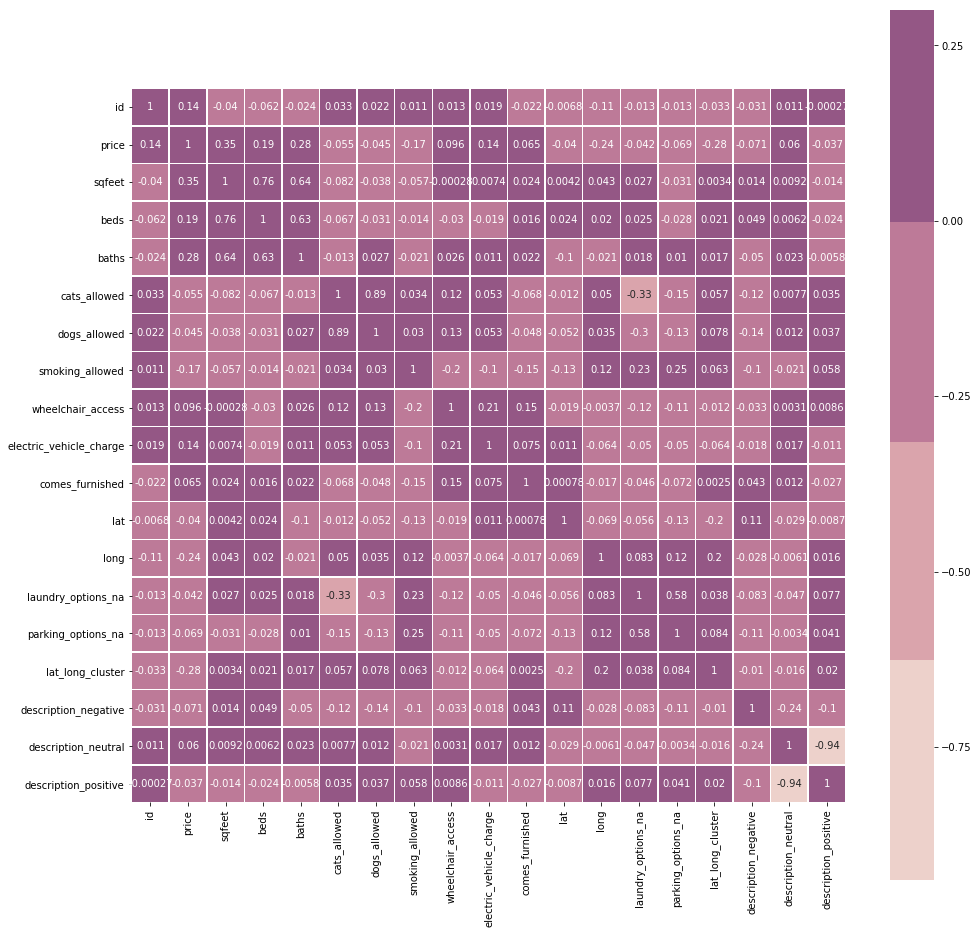

In [50]:
clean_df.corr()
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(clean_df.corr(), annot=True, linewidths=0.5, square=True, vmax=0.3, center=0, cmap=sns.cubehelix_palette())

In [51]:
# kernel stop here

In [52]:
clean_df.to_csv('clean_df.csv', index = False)
clean_df.head()

,id,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,...,parking_options,lat,long,state,laundry_options_na,parking_options_na,lat_long_cluster,description_negative,description_neutral,description_positive
0,7039061606,birmingham,1195,apartment,1908,3,2.0,1,1,1,...,street parking,33.4226,-86.7065,al,0,0,5,0.005,0.875,0.120
1,7041970863,birmingham,1120,apartment,1319,3,2.0,1,1,1,...,off-street parking,33.3755,-86.8045,al,0,0,5,0.000,0.771,0.229
2,7041966914,birmingham,825,apartment,1133,1,1.5,1,1,1,...,street parking,33.4226,-86.7065,al,0,0,5,0.005,0.876,0.119
3,7041966936,birmingham,800,apartment,927,1,1.0,1,1,1,...,street parking,33.4226,-86.7065,al,0,0,5,0.005,0.875,0.120
4,7041966888,birmingham,785,apartment,1047,2,1.0,1,1,1,...,street parking,33.4226,-86.7065,al,0,0,5,0.005,0.888,0.107


## 3) Model Building

In [67]:
df = pd.read_csv("clean_df.csv")
df.drop(['state'], axis=1, inplace=True)
df.T

,0,1,2,3,4,5,6,7,8,9,...,258408,258409,258410,258411,258412,258413,258414,258415,258416,258417
id,7039061606,7041970863,7041966914,7041966936,7041966888,7041966868,7041966702,7041964186,7041960353,7041959413,...,7042630914,7050893893,7050889024,7050888314,7050888285,7049194586,7050888256,7050887997,7044801015,7050885800
region,birmingham,birmingham,birmingham,birmingham,birmingham,birmingham,birmingham,birmingham,birmingham,birmingham,...,columbus,columbus,columbus,columbus,columbus,columbus,columbus,columbus,columbus,columbus
price,1195,1120,825,800,785,900,925,1085,1269,799,...,890,1164,760,1601,1719,870,929,1069,1507,1001
type,apartment,apartment,apartment,apartment,apartment,apartment,apartment,house,apartment,apartment,...,apartment,townhouse,apartment,apartment,apartment,apartment,apartment,apartment,apartment,apartment
sqfeet,1908,1319,1133,927,1047,1298,1350,2308,1156,703,...,756,1300,794,1222,1630,933,728,1020,1660,1220
beds,3,3,1,1,2,2,2,3,3,1,...,1,2,1,2,3,2,1,2,2,3
baths,2,2,1.5,1,1,2,2,2,2,1,...,1,2.5,1,2,2.5,2,1,1.5,1.5,1.5
cats_allowed,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
dogs_allowed,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
smoking_allowed,1,1,1,1,1,1,1,0,1,1,...,0,0,1,1,1,1,1,1,1,1


In [54]:
# df.state.value_counts()

In [55]:
df.dropna(inplace=True)
df.shape

(258418, 23)

In [56]:
df = pd.get_dummies(df,drop_first=False)
df.head()

,id,price,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,...,laundry_options_no laundry on site,laundry_options_w/d hookups,laundry_options_w/d in unit,parking_options_attached garage,parking_options_carport,parking_options_detached garage,parking_options_no parking,parking_options_off-street parking,parking_options_street parking,parking_options_valet parking
0,7039061606,1195,1908,3,2.0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,7041970863,1120,1319,3,2.0,1,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,7041966914,825,1133,1,1.5,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,7041966936,800,927,1,1.0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,7041966888,785,1047,2,1.0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [57]:
# df = df.iloc[:1000, :]

In [58]:
df_X = df.drop(["id", "price"], axis=1)
df_y = df.loc[:, "price"]

In [59]:
scaler = MinMaxScaler()
df_X = scaler.fit_transform(df_X)
# X_test = scaler.transform(X_test)
print(df_X)


[[0.46984288 0.5        0.57142857 ... 0.         1.         0.        ]
 [0.3205778  0.5        0.57142857 ... 1.         0.         0.        ]
 [0.27344146 0.16666667 0.42857143 ... 0.         1.         0.        ]
 ...
 [0.24480487 0.33333333 0.42857143 ... 0.         0.         0.        ]
 [0.40699442 0.33333333 0.42857143 ... 0.         0.         0.        ]
 [0.2954891  0.5        0.42857143 ... 1.         0.         0.        ]]


In [60]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

In [61]:
# X_train = X_train.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)

# X_test = X_test.reset_index(drop=True)
# y_test = y_test.reset_index(drop=True)

In [62]:
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# regressor = Sequential()
# # Adding the first LSTM layer and some Dropout regularisation
# regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# regressor.add(Dropout(0.2))
# regressor.add(LSTM(units = 50, return_sequences = True))
# regressor.add(Dropout(0.2))
# regressor.add(LSTM(units = 50, return_sequences = True))
# regressor.add(Dropout(0.2))
# regressor.add(LSTM(units = 50))
# regressor.add(Dropout(0.2))

# regressor.add(Dense(units = 1))

# regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
# regressor.fit(X_train, y_train, epochs = 1, batch_size = 5)

In [63]:
from sklearn import metrics as skmetrics

def calculate_regression_metrics(y_test, predictions):
    mean_squared_error = skmetrics.mean_squared_error(y_test, predictions)
    mean_absolute_error = skmetrics.mean_absolute_error(y_test, predictions)
    r2_error = skmetrics.r2_score(y_test, predictions)
    result = {'mean_squared_error': mean_squared_error, 'mean_absolute_error': mean_absolute_error, 'r2_score': r2_error}
    return result 

In [64]:
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn import linear_model

# poly = PolynomialFeatures(degree=2)
# X_train_ = poly.fit_transform(X_train)
# X_test_ = poly.fit_transform(X_test)

# clf = linear_model.LinearRegression()
# clf.fit(X_, y_train)
# ppp = clf.predict(X_test_)
# print(skmetrics.r2_score(y_test, ppp))

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_test)
pred = pred.reshape(-1, 1)

# pred = scalery.inverse_transform(pred)
# y_test = scalery.inverse_transform(y_test)

print(pred)
print("//////////////////////////////////////")
print(y_test)
print("//////////////////////////////////////")

calculate_regression_metrics(y_test, pred)

[[ 811. ]
 [ 520. ]
 [1530. ]
 ...
 [1179.5]
 [1399. ]
 [ 638. ]]
//////////////////////////////////////
253224     891
121678     520
58863     1530
233419    1245
107210    1245
209733    1370
217533     575
223220     725
234679    1530
186420    1290
157018    1209
149713     628
213725     795
232663    1375
177326     995
7950       800
218914     830
107515     499
25151     1250
181478    1699
113779    2400
38387     1400
116152     975
155410     799
250193    1000
184947     960
105689     999
236619     771
77931     1850
255940     660
          ... 
247224    1400
116914    1225
175821    1500
39493     1975
257871     792
43069     2058
204393    1650
58890     1335
144306    1563
179146     995
165226    1360
209188    1169
56593      950
114635    1425
245311     995
152766     799
176945    1076
52351     1600
226501    1200
38072     1239
221827     795
87376     1360
95943      929
241284    3250
68795     1250
77653     1150
47235     1880
21970     1200
20597     

{'mean_squared_error': 44599.7210777054,
 'mean_absolute_error': 86.38916082508531,
 'r2_score': 0.8810939118031855}

In [66]:
# fig, ax = plt.subplots(1, 1, figsize=(21,21))
# ax.scatter(range(y_test.size), y_test)
# ax.scatter(range(y_test.size), pred)

# # ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
# ax.set_xlabel('Measured')
# ax.set_ylabel('Predicted')
# plt.show()

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(21,21))
# ax.plot(y_test)
# ax.plot(pred)

In [ ]:
# xg_reg = xgb.XGBRegressor(n_jobs=6)
# xg_reg.fit(X_train, y_train)
# xg_reg = xg_reg.predict(X_test)


# pred = xg_reg.reshape(-1, 1)

# # pred = scalery.inverse_transform(pred)
# # y_test = scalery.inverse_transform(y_test)

# print(pred)
# print("//////////////////////////////////////")
# print(y_test)
# print("//////////////////////////////////////")



# calculate_regression_metrics(y_test, pred)